## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images","regressionmlp")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Regression MLP on California Housing Dataset

Let's load, split and scale the dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - val_loss: 0.4656

Let's plot the learning curves

In [5]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

Saving figure california_learning_curves


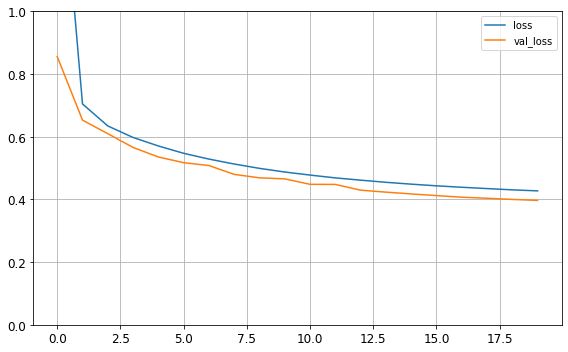

In [6]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("california_learning_curves")
plt.show()

From learning curves, we can see the model is good. In fact, the validation loss is less than training loss. This happens because regularisation is applied during training but not during validation.

In [7]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022797 ]], dtype=float32)

In [8]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

Meaning it is not converged and if we train it for more longer the model will perform better.

Till now we have used sequential API. Let's use Functional API

## Functional API

Let's build the neural network as shown in the figure called as Wide & Deep neural network on california housing dataset.
<img src="images/widedeepnn.png" width = 500 height = 500/>

In [3]:
input_ = keras.layers.Input(shape = X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation = "relu")(input_)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs = [input_], outputs = [output])

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [7]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4306 - val_loss: 0.3996
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4271 - val_loss: 0.3964
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4232 - val_loss: 0.4072
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4214 - val_loss: 0.3986
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4179 - val_loss: 0.3877
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4150 - val_loss: 0.3887
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4123 - val_loss: 0.4156
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4101 - val_loss: 0.4781
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4086 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4070 - val_loss: 0.3834

Suppose what if we want to send different subsets of input features through the wide or deep paths? Let's send 5 features through wide path(featuers 0 to 4), and 6 through deep path(featuers 2 t0 7). Note than 3 features wil go through both (features 2,3,4)
<img src="images/multipledeep.png" width = 500 height = 500/>

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
input_A = keras.layers.Input(shape = [5], name = "wide_input")
input_B = keras.layers.Input(shape = [6], name = "deep_input")
hidden_1 = keras.layers.Dense(30, activation = "relu")(input_B)
hidden_2 = keras.layers.Dense(30, activation = "relu")(hidden_1)
concat = keras.layers.concatenate([input_A, hidden_2])
output = keras.layers.Dense(1, name = "output")(concat)
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output])

In [10]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4644 - val_loss: 0.4315

We can also add auxillay output for regularisation as shown in the figure below.
<img src = "images/auxi.png" width = 500, height = 500/>

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
input_A = keras.layers.Input(shape = [5], name = "wide_input")
input_B = keras.layers.Input(shape = [6], name = "deep_input")
hidden_1 = keras.layers.Dense(30, activation = "relu")(input_B)
hidden_2 = keras.layers.Dense(30, activation = "relu")(hidden_1)
concat = keras.layers.concatenate([input_A, hidden_2])
output = keras.layers.Dense(1, name = "main_output")(concat)
aux_output = keras.layers.Dense(1, name = "aux_output")(hidden_2)
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output, aux_output])

In [13]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [14]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [15]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 912us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


## The Subclassing the API

In [16]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units = 30, activation = "relu", **kwargs):
        super().__init__(*kwargs)
        self.hidden1 = keras.layers.Dense(units, activation = activation)
        self.hidden2 = keras.layers.Dense(units, activation = activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
model = WideAndDeepModel(30, activation = "relu")

In [17]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

## TensorBoard

In [19]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [20]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_10_07-12_41_25'

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [23]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 4ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

In [25]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21324), started 0:01:02 ago. (Use '!kill 21324' to kill it.)

In [26]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2020_10_07-12_46_08'

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [29]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5530 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 1s 1ms/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 1s 1ms/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 1s 1ms/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3425 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3433 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 1s 1ms/step - loss: 1.3435 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 1s 1ms/step - loss: 1.3423 - val_l

In [30]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



By Using tf.summary API we can visualize the scalars, histograms, images, texts, audio and many more.

In [31]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        data = (np.random.randn(100) + 2) * step / 100 # some random data
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        images = np.random.rand(2, 32, 32, 3) # random 32×32 RGB images
        tf.summary.image("my_images", images * step / 1000, step=step)
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text", texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

## Hyperparameter Tuning

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [34]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Let's explore number of hidden layers, number of neurons and learning rate for finding best model.

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [36]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [37]:
rnd_search_cv.best_score_

-0.34988951683044434